## Predicting Flooding in Kathmandu

In this lab, we will use DEM dataset for Kathmandu to predict areas that are at the highest risk of flooding.

In [9]:
import os, os.path
import numpy as np
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import get_data_window
from rasterio.windows import Window
from rasterio.merge import merge
# optional - turn off warnings
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')
# This function is used to mosaic geotiffs in the input folder
# Parameters:
#     dirpath: the folder name of the tif files
#     outfile: the output file of the mosaiced geotiff imag
import rasterio
import fiona
import os, os.path
import glob
from shapely.geometry import Polygon
from shapely.geometry import shape
import requests
import zipfile
from dotenv import load_dotenv

DEM data is available via NASA earthdata portal. To download, we set up the sesison as follows.

In [10]:
# Load environment variables from .env file
load_dotenv()

# Get credentials from environment variables
username = os.getenv("NASA_EARTHDATA_USERNAME")
password = os.getenv("NASA_EARTHDATA_PASSWORD")

# Set up netrc file for authentication
netrc_path = os.path.expanduser("~/.netrc")
if not os.path.exists(netrc_path):
    with open(netrc_path, "w") as f:
        f.write(f"machine urs.earthdata.nasa.gov login {username} password {password}\n")
    os.chmod(netrc_path, 0o600)  # Set permissions to be user readable/writable only

# Create a session
session = requests.Session()

# NASA Earthdata login URL
auth_url = "https://urs.earthdata.nasa.gov/oauth/authorize"

# Authenticate with NASA Earthdata
session.auth = (username, password)

In [11]:
# Define the base URL for NASADEM_HGT data
base_url = "https://e4ftl01.cr.usgs.gov/MEASURES/NASADEM_HGT.001/2000.02.11/"

# Define the tiles covering Kathmandu 27, 85
ktm_tiles = ["NASADEM_HGT_n27e085.zip"]

# Create directory to save files
save_directory = "data/dem"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Download each tile
for tile in ktm_tiles:
    # Construct the full URL
    url = base_url + tile
    
    # Path to save the downloaded file
    output_zip = os.path.join(save_directory, tile)
    
    # Make a head request first to get redirected to the Earthdata login
    response = session.get(url, allow_redirects=True, stream=True)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Save the zip file
        with open(output_zip, "wb") as file:
            for chunk in response.iter_content(1024 * 1024):  # 1MB chunks
                file.write(chunk)
        
        print(f"Downloaded {tile} successfully")
        
        # Extract immediately after successful download
        try:
            with zipfile.ZipFile(output_zip, "r") as zip_file:
                # Extract all contents to the save directory
                zip_file.extractall(save_directory)
                print(f"Extracted contents from {tile}")
        except Exception as e:
            print(f"Error extracting {tile}: {e}")
    else:
        print(f"Failed to download {tile}. Status code: {response.status_code}")
        print(f"Response: {response.text[:200]}...")  # Print the first 200 chars of response

print("Processing complete!")

Downloaded NASADEM_HGT_n27e085.zip successfully
Extracted contents from NASADEM_HGT_n27e085.zip
Processing complete!


However, the data is in hgt format. I will convert it to Geotiff using gdal.

In [12]:
import subprocess

hgt_file = "data/dem/n27e085.hgt"

tif_path = hgt_file.replace('.hgt', '.tif')

cmd = ['gdal_translate', '-of', 'GTiff', hgt_file, tif_path]

subprocess.run(cmd, check=True)

Input file size is 3601, 3601
0...10...20...30...40...50...60...70...80...90...100 - done.


CompletedProcess(args=['gdal_translate', '-of', 'GTiff', 'data/dem/n27e085.hgt', 'data/dem/n27e085.tif'], returncode=0)

Now, let us clip the DEM data to the shape of Kathmandu.

In [20]:
import rasterio
import geopandas as gpd
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import from_bounds
import os

boundary = gpd.read_file("maincity.geojson")

tif_path = "data/dem/n27e085.tif"
output_path = "data/dem/n27e085_clipped.tif"

with rasterio.open(tif_path) as src:
        # Reproject boundary to match DEM's CRS if needed
        boundary = boundary.to_crs(src.crs)
        
        # Get the total bounds (minx, miny, maxx, maxy)
        minx, miny, maxx, maxy = boundary.total_bounds
        
        # Create a window from the bounds
        window = from_bounds(minx, miny, maxx, maxy, src.transform)
        
        # Read the data in the window
        out_image = src.read(window=window)
        
        # Calculate the transform for the window
        out_transform = src.window_transform(window)
        
        # Copy the metadata
        out_meta = src.meta.copy()
        
        # Update the metadata
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        
        # Write the clipped raster
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

Finally, as we are working with an urban area that is very small, it would be nice if we can increase the resolution of our satellite image. Therefore, we will use interpolation to increase the resolution of the DEM data.

In [30]:
input_dem = "data/dem/n27e085_clipped.tif"
scale_factor = 2 
output_dem = "data/dem/n27e085_clipped_enhanced.tif"

with rasterio.open(input_dem) as src:
        # Calculate new dimensions
        new_height = int(src.height * scale_factor)
        new_width = int(src.width * scale_factor)
        
        # Calculate new transform (maintaining the same geographic extent)
        new_transform = rasterio.transform.from_bounds(
            src.bounds.left, src.bounds.bottom, 
            src.bounds.right, src.bounds.top, 
            new_width, new_height
        )
        
        # Update metadata for the new raster
        out_meta = src.meta.copy()
        out_meta.update({
            "height": new_height,
            "width": new_width,
            "transform": new_transform
        })
        
        # Create the resampled raster
        with rasterio.open(output_dem, "w", **out_meta) as dest:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dest, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=new_transform,
                    dst_crs=src.crs,
                    resampling=Resampling.cubic  # Cubic interpolation for smoother results
                )

Now that our data is ready, we can start our flood modeling.

In [31]:
import numpy as np
import pysheds
from pysheds.grid import Grid

# Instantiate grid from raster
grid = Grid.from_raster('data/dem/n27e085_clipped_enhanced.tif', data_name='dem')
dem = grid.read_raster('data/dem/n27e085_clipped_enhanced.tif', data_name='dem')

In [32]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [33]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

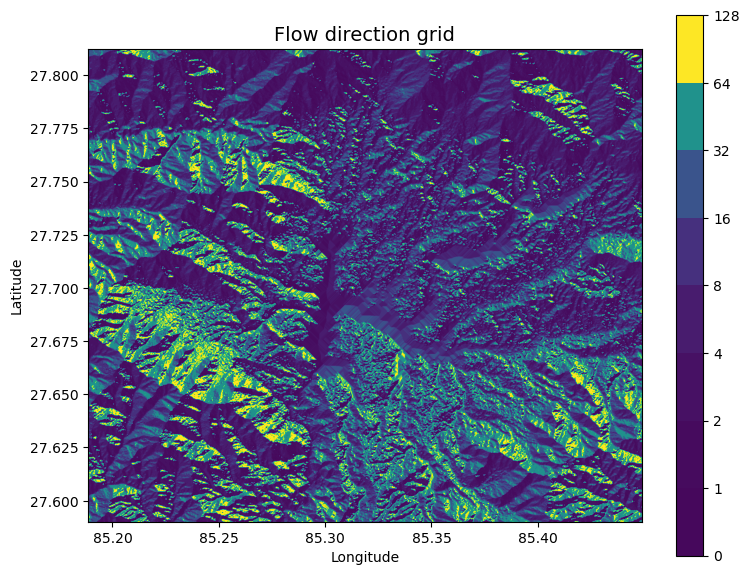

In [34]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [35]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

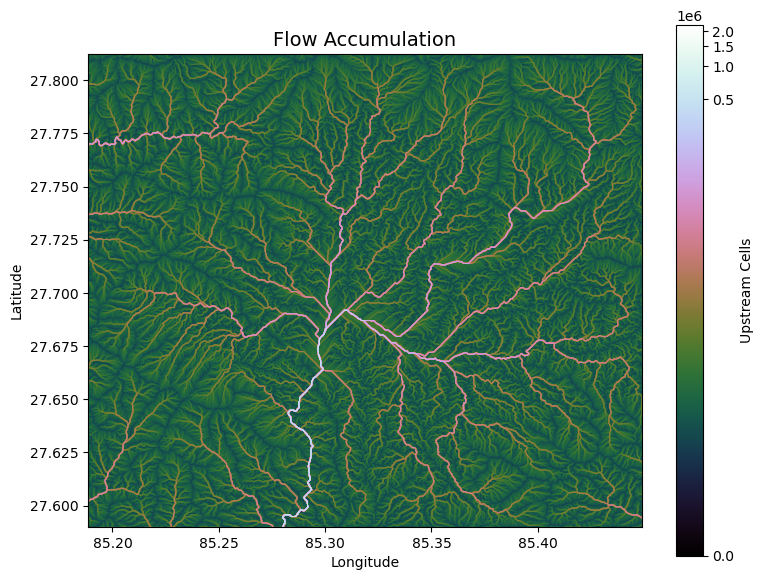

In [36]:
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.PowerNorm(gamma=0.1, vmin=acc.min(), vmax=acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [37]:

# Compute height above nearest drainage
hand = grid.compute_hand(fdir, dem, acc > 200)


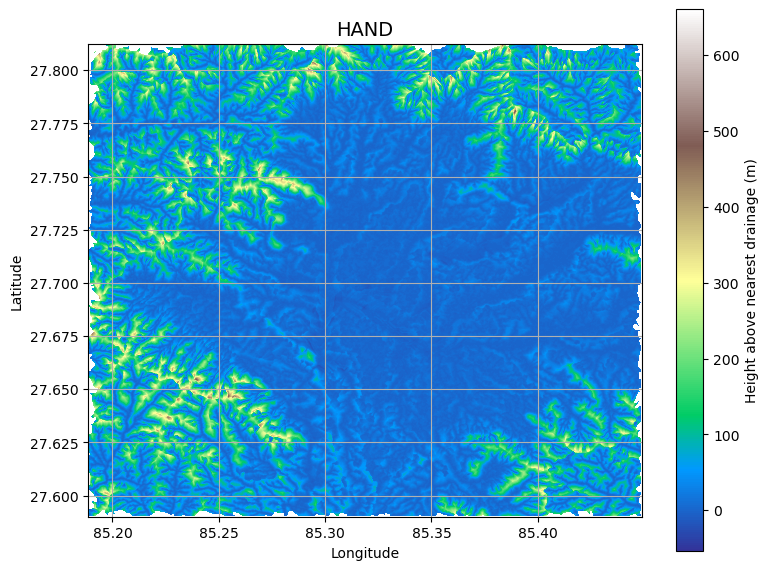

In [38]:
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.imshow(hand, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Height above nearest drainage (m)')
plt.grid(zorder=0)
plt.title('HAND', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [39]:
threshold = 5
inundation_extent = np.where(hand < threshold, threshold - hand, np.nan)

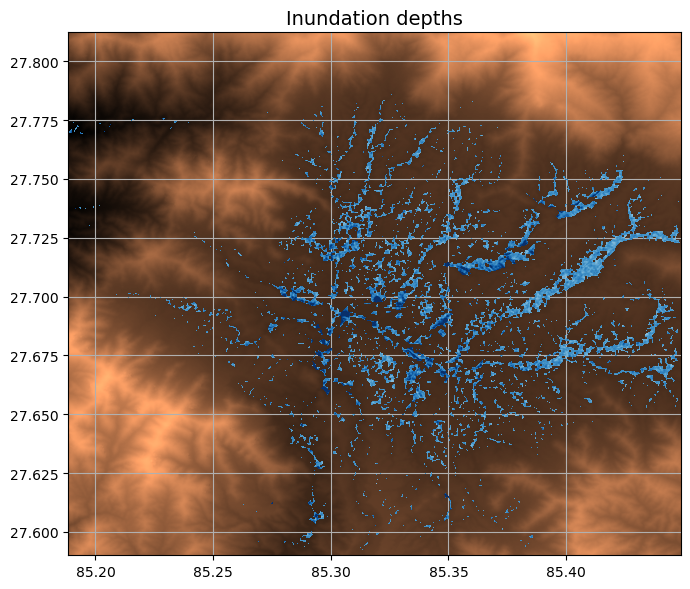

In [47]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
dem_view = grid.view(dem, nodata=np.nan)
plt.imshow(dem_view, extent=grid.extent, cmap='copper', zorder=1)
plt.imshow(inundation_extent, extent=grid.extent,
           cmap='Blues', vmin=-5, vmax=10, zorder=2)
plt.grid(zorder=0)
plt.title('Inundation depths', size=14)
plt.tight_layout()

Finally, let us export our innundation map to a geotiff file.

In [49]:
from rasterio.transform import from_bounds

# Get the bounds from grid
xmin, ymin, xmax, ymax = grid.extent

# Create the transform based on grid dimensions
transform = from_bounds(xmin, ymin, xmax, ymax, 
                        inundation_extent.shape[1], inundation_extent.shape[0])

# Define metadata for the output file
output_meta = {
    'driver': 'GTiff',
    'height': inundation_extent.shape[0],
    'width': inundation_extent.shape[1],
    'count': 1,
    'dtype': inundation_extent.dtype,
    'crs': grid.crs, 
    'transform': transform,
    'nodata': -9999
}

# Write the file
output_path = 'data/dem/inundation_depths.tif'
with rasterio.open(output_path, 'w', **output_meta) as dst:
    # Replace any NaN values with nodata value
    inundation_for_export = np.copy(inundation_extent)
    inundation_for_export[np.isnan(inundation_for_export)] = -9999
    dst.write(inundation_for_export, 1)